### 그래프 한글 안 깨지게 하는 코드

In [1]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/Pal-ette/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

### 모듈 불러오기


In [2]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

### 데이터 압축풀기

In [3]:
!unzip -q "/content/drive/MyDrive/CV_project/data/안구질환/개_안구_정상_아픔.zip"


### 하이퍼파라미터 설정



In [12]:
batch_size = 64
img_size = 224
learning_rate = 5e-4
epochs = 30


classes_labels= [
    '아픔',
    '정상',
]

num_classes = len(classes_labels)
base_dir = '/content/개_안구_정상_아픔_ttv'

In [5]:
import os

base_dir = '/content/개_안구_정상_아픔'

for root, dirs, files in os.walk(base_dir):
    if root != base_dir:  # base_dir 자체는 제외
        num_images = sum(1 for file in files if file.endswith('.jpg') or file.endswith('.png'))  # jpg, png 이미지 확인
        print(f"{os.path.basename(root)}: {num_images} images")


아픔: 113689 images
정상: 85139 images


In [7]:
!pip install split-folders

In [8]:
import splitfolders

splitfolders.ratio(base_dir, output="개_안구_정상_아픔_ttv", seed=1337, ratio=(.8, 0.1, 0.1))

Copying files: 198874 files [00:25, 7815.56 files/s]


In [ ]:
!zip -r /content/drive/MyDrive/CV_project/data/안구질환/개_안구_정상_아픔_ttv.zip /content/개_안구_정상_아픔_ttv

In [13]:
# 이미지 증강이 적용된 데이터 제너레이터 선언
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 이미지 픽셀 값을 0 ~ 1 사이로 정규화
    width_shift_range=0.1,     # 이미지를 가로로 10% 범위 내에서 무작위 이동
    height_shift_range=0.1,    # 이미지를 세로로 10% 범위 내에서 무작위 이동
    zoom_range=0.1,           # 이미지를 10% 범위 내에서 무작위 확대/축소
    horizontal_flip=True,      # 이미지를 좌우로 무작위 반전
)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 검증 데이터에도 동일한 정규화 적용
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255          # 테스트 데이터에도 동일한 정규화 적용
)

# flow_from_directory: 디렉토리에서 이미지를 불러와 배치 단위로 제공
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  # 훈련 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 ()
    class_mode='binary',        # 다중 클래스 분류이므로 'categorical' 설정
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),    # 검증 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 ()
    class_mode='binary',        # 다중 클래스 분류이므로 'categorical' 설정
    follow_links=True        # 숨김 파일 무시
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),   # 테스트 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 ()
    class_mode='binary'         # 다중 클래스 분류이므로 'categorical' 설정
)


Found 159073 images belonging to 2 classes.
Found 19883 images belonging to 2 classes.
Found 19884 images belonging to 2 classes.


### 이미지 확인

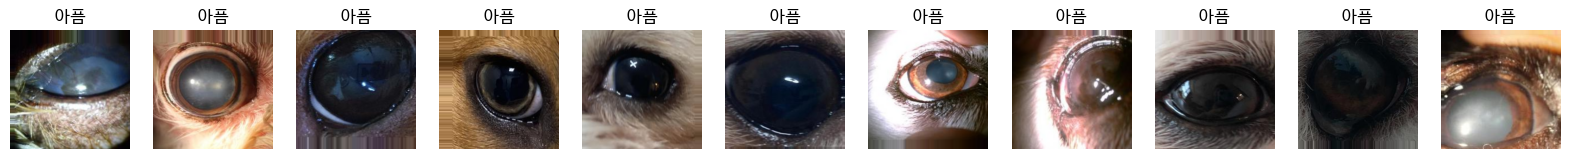

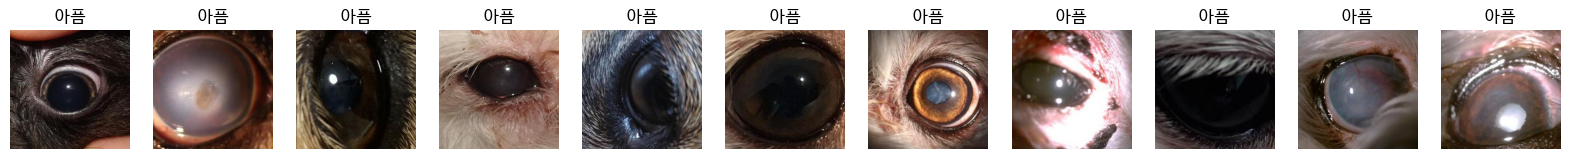

In [14]:
def show_images(generator, num_images=11):
    image, labels = next(generator)
    plt.figure(figsize=(20, 20))  # 이미지 개수에 따라 figsize 조절

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[i])

        # 클래스 레이블에 맞는 제목 설정
        class_index = np.argmax(labels[i])  # one-hot encoded labels에서 클래스 인덱스 추출

        # Check if class_index is within the range of classes_labels
        if class_index >= len(classes_labels):
            class_index = 0

        class_name = classes_labels[class_index]
        plt.title(class_name)

        plt.axis('off')
    plt.show()

show_images(train_generator, num_images=11)  # 모든 클래스 이미지 확인
show_images(test_generator, num_images=11)

## 모델 구현
* ResNet50v2 사용


In [24]:
# 모델 불러오기 및 선언
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(img_size, img_size, 3),  # 입력 이미지 크기 (224x224x3)
    include_top=False,                    # 사전 학습된 모델의 마지막 분류 레이어 제외
    weights='imagenet',                   # ImageNet 데이터셋으로 사전 학습된 가중치 사용
    pooling='avg'                         # 특징 맵을 평균 풀링하여 1차원 벡터로 변환
)

inputs = base_model.input                 # 입력 레이어 설정 (base_model의 입력 사용)
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)  # 128개 노드의 은닉층 추가 (ReLU 활성화 함수 사용)
x = tf.keras.layers.Dropout(0.1)(x)       # 과적합 방지를 위한 드롭아웃 레이어 추가 (10% 드롭아웃)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # 출력 레이어 설정 (클래스 개수만큼 출력 노드, softmax 활성화 함수 사용)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)  # 입력과 출력을 연결하여 모델 생성

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

### 모델 컴파일링


In [25]:
# ophtimizer 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 콜백함수
callback = [ReduceLROnPlateau(monitor='val_loss', mode = 'min', factor=0.1, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_all_정상_아픔.tf', monitor='val_loss', mode='min', save_best_only=True)]

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)


## 모델 학습'


In [26]:
histroy = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callback
)

Epoch 1/30
2486/2486 [==============================] - 1745s 686ms/step - loss: 0.1403 - accuracy: 0.9447 - precision_3: 0.9145 - recall_3: 0.9605 - auc_3: 0.9854 - val_loss: 0.1304 - val_accuracy: 0.9513 - val_precision_3: 0.9142 - val_recall_3: 0.9782 - val_auc_3: 0.9873 - lr: 5.0000e-04
Epoch 2/30
2486/2486 [==============================] - 1669s 671ms/step - loss: 0.1143 - accuracy: 0.9550 - precision_3: 0.9303 - recall_3: 0.9673 - auc_3: 0.9902 - val_loss: 0.1386 - val_accuracy: 0.9433 - val_precision_3: 0.9571 - val_recall_3: 0.9084 - val_auc_3: 0.9900 - lr: 5.0000e-04
Epoch 3/30
2486/2486 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9594 - precision_3: 0.9381 - recall_3: 0.9692 - auc_3: 0.9920
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
2486/2486 [==============================] - 1670s 672ms/step - loss: 0.1033 - accuracy: 0.9594 - precision_3: 0.9381 - recall_3: 0.9692 - auc_3: 0.9920 - val_loss: 0.1442 - val_accura

## 평가지표


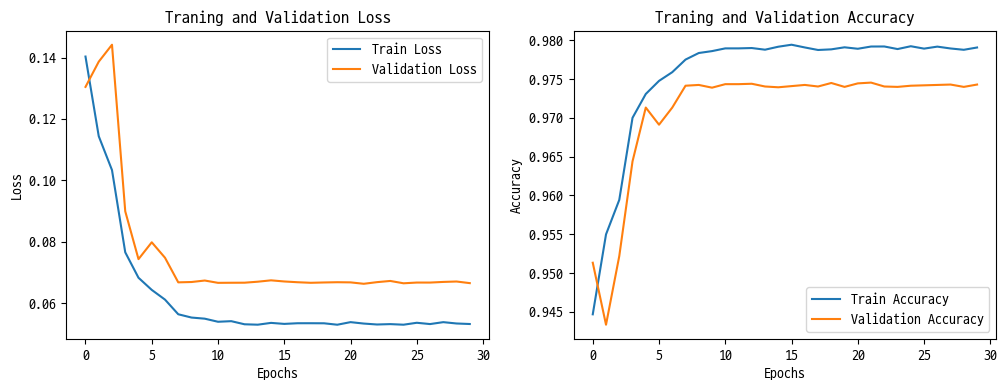

In [27]:
# 학습 로그 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(30), histroy.history['loss'], label='Train Loss')
plt.plot(range(30), histroy.history['val_loss'], label='Validation Loss')
plt.title('Traning and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(30), histroy.history['accuracy'], label='Train Accuracy')
plt.plot(range(30), histroy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/CV_project/안구질환_모델/Resnet_squared_all_정상_아픔.tf')

trained_model.evaluate(test_generator)

311/311 [==============================] - 56s 176ms/step - loss: 0.0664 - accuracy: 0.9746 - precision_3: 0.9639 - recall_3: 0.9773 - auc_3: 0.9963


[0.06636400520801544,
 0.9746026992797852,
 0.9638637900352478,
 0.9773341417312622,
 0.9963295459747314]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')

# 테스트 데이터를 바탕으로 혼동 행렬 계산
predictions = trained_model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
predicted_classes = (predictions > 0.5).astype('int').flatten()

# 필요한 경우 steps 인자에 맞게 예측 값을 재조정
if len(predicted_classes) > test_generator.samples:
    predicted_classes = predicted_classes[:test_generator.samples]

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(f"true_classes length: {len(true_classes)}")
print(f"predicted_classes length: {len(predicted_classes)}")

if len(true_classes) == len(predicted_classes):
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plot_confusion_matrix(conf_matrix, classes=class_labels, title='Confusion Matrix')
    plt.show()
else:
    print("Error: The number of true classes and predicted classes do not match.")
